<a href="https://colab.research.google.com/github/ashishkej/eva8_session8/blob/main/EVA8_Session8_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA8 Sesson8 Assignment Colab Notebook
## Write a custom ResNet architecture for CIFAR10 and train using OCP

# Installing required Libraries

In [1]:
!pip install grad-cam
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=557f449b2b326196c616b22fdce51b66eea96217c39df654f19d155e5d11d7bc
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Cloning Main repo containing models, training code and utils functions

In [2]:
!git clone https://github.com/ashishkej/eva8-pytorch-models

Cloning into 'eva8-pytorch-models'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 73 (delta 28), reused 59 (delta 17), pack-reused 0
Unpacking objects: 100% (73/73), 17.30 KiB | 984.00 KiB/s, done.


In [3]:
import sys 
sys.path.append('/content/eva8-pytorch-models')

In [4]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [5]:
from torchsummary import summary
from models import custom_resnet
net = custom_resnet.MyResnet().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1, 128,

In [6]:
import main
import utils

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


In [8]:
import torchvision
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(utils.AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(utils.AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
import copy
import torch.nn.functional as F
from torch_lr_finder import LRFinder

# Finding Learning rate using LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.21E-01


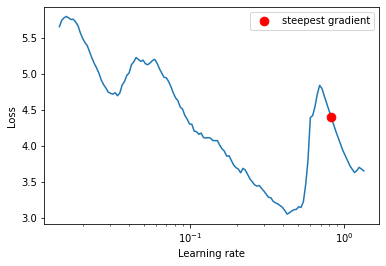

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.8214343584919427)

In [10]:
net = custom_resnet.MyResnet().to(device)
net1_exp = copy.deepcopy(net)
optimizer = torch.optim.SGD(net1_exp.parameters(), lr=0.01, momentum=0.9)
criterion = F.nll_loss
lr_finder = LRFinder(net1_exp, optimizer, criterion, device=device)
lr_finder.range_test(test_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [11]:
import numpy as np
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.42475715525368996


#Training using OCP

In [13]:
net = custom_resnet.MyResnet().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                ) #final_div_factor=100,

net, history = main.fit_model(net, device, train_loader, test_loader,optimizer, scheduler,NUM_EPOCHS=24)

EPOCH: 1 (LR: 0.042475715525368996)


Batch_id=97 Loss=6.74808 Accuracy=10.81: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]



Test set: Average loss: 2.3019, Accuracy: 1159/10000 (11.59%)

EPOCH: 2 (LR: 0.08213669714773691)


Batch_id=97 Loss=2.21897 Accuracy=17.33: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 2.0595, Accuracy: 2496/10000 (24.96%)

EPOCH: 3 (LR: 0.18466063250218737)


Batch_id=97 Loss=1.99320 Accuracy=25.85: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]



Test set: Average loss: 1.9019, Accuracy: 3107/10000 (31.07%)

EPOCH: 4 (LR: 0.3075008583885875)


Batch_id=97 Loss=1.90194 Accuracy=30.19: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 1.8440, Accuracy: 3318/10000 (33.18%)

EPOCH: 5 (LR: 0.3996796036147974)


Batch_id=97 Loss=1.77357 Accuracy=34.66: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 2.0062, Accuracy: 3341/10000 (33.41%)

EPOCH: 6 (LR: 0.42463179841922777)


Batch_id=97 Loss=1.64608 Accuracy=39.31: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 1.6075, Accuracy: 4301/10000 (43.01%)

EPOCH: 7 (LR: 0.42061519250048957)


Batch_id=97 Loss=1.58535 Accuracy=41.53: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 1.5047, Accuracy: 4496/10000 (44.96%)

EPOCH: 8 (LR: 0.4110472386370135)


Batch_id=97 Loss=1.50061 Accuracy=44.46: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 1.5712, Accuracy: 4377/10000 (43.77%)

EPOCH: 9 (LR: 0.39618352879356294)


Batch_id=97 Loss=1.44443 Accuracy=46.68: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 1.3722, Accuracy: 5079/10000 (50.79%)

EPOCH: 10 (LR: 0.37642112224286917)


Batch_id=97 Loss=1.38240 Accuracy=49.13: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 1.3364, Accuracy: 5086/10000 (50.86%)

EPOCH: 11 (LR: 0.35228793878793474)


Batch_id=97 Loss=1.33306 Accuracy=51.21: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]



Test set: Average loss: 1.3255, Accuracy: 5207/10000 (52.07%)

EPOCH: 12 (LR: 0.324428656263044)


Batch_id=97 Loss=1.27449 Accuracy=53.69: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 1.4904, Accuracy: 4786/10000 (47.86%)

EPOCH: 13 (LR: 0.2935874890382741)


Batch_id=97 Loss=1.22737 Accuracy=55.75: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]



Test set: Average loss: 1.1805, Accuracy: 5779/10000 (57.79%)

EPOCH: 14 (LR: 0.2605883075710969)


Batch_id=97 Loss=1.17385 Accuracy=57.61: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 1.1995, Accuracy: 5713/10000 (57.13%)

EPOCH: 15 (LR: 0.22631263007816824)


Batch_id=97 Loss=1.12255 Accuracy=59.63: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 1.0787, Accuracy: 6100/10000 (61.00%)

EPOCH: 16 (LR: 0.1916760742431657)


Batch_id=97 Loss=1.08673 Accuracy=60.84: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]



Test set: Average loss: 1.1193, Accuracy: 5977/10000 (59.77%)

EPOCH: 17 (LR: 0.15760389801411273)


Batch_id=97 Loss=1.04441 Accuracy=62.18: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]



Test set: Average loss: 1.0266, Accuracy: 6378/10000 (63.78%)

EPOCH: 18 (LR: 0.12500628287708324)


Batch_id=97 Loss=1.00981 Accuracy=63.68: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.9884, Accuracy: 6466/10000 (64.66%)

EPOCH: 19 (LR: 0.09475401987249749)


Batch_id=97 Loss=0.97948 Accuracy=64.51: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 0.9767, Accuracy: 6586/10000 (65.86%)

EPOCH: 20 (LR: 0.06765524786162198)


Batch_id=97 Loss=0.94465 Accuracy=65.96: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.9127, Accuracy: 6741/10000 (67.41%)

EPOCH: 21 (LR: 0.04443386544177036)


Batch_id=97 Loss=0.91670 Accuracy=67.07: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]



Test set: Average loss: 0.8970, Accuracy: 6836/10000 (68.36%)

EPOCH: 22 (LR: 0.02571019319996651)


Batch_id=97 Loss=0.89303 Accuracy=67.90: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 0.8845, Accuracy: 6887/10000 (68.87%)

EPOCH: 23 (LR: 0.011984402880781139)


Batch_id=97 Loss=0.87321 Accuracy=68.76: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.8633, Accuracy: 6932/10000 (69.32%)

EPOCH: 24 (LR: 0.003623156130546231)


Batch_id=97 Loss=0.86631 Accuracy=68.84: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]



Test set: Average loss: 0.8633, Accuracy: 6960/10000 (69.60%)



# Learning Rate plot during 24 epochs

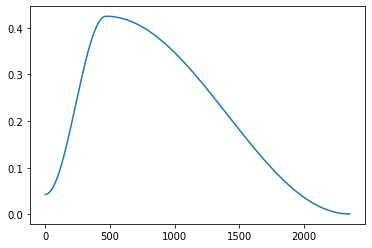

In [14]:
import matplotlib.pyplot as plt
plt.plot(history[4])